<a href="https://colab.research.google.com/github/Abirelbahri/Speech-Emotion-Recognition/blob/main/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa tensorflow

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

print("Libraries installed successfully!")

Libraries installed successfully!


In [12]:


# The link for the Audio_Speech_Actors_01-24.zip file from the official source
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip

# Unzip the downloaded file
!unzip Audio_Speech_Actors_01-24.zip

# The unzipped folder structure is slightly different.
# Let's move it to match the expected 'ravdess_data' path.
!mkdir -p ravdess_data
!mv Audio_Speech_Actors_01-24 ravdess_data/

# Clean up
!rm Audio_Speech_Actors_01-24.zip

print("Dataset downloaded and unzipped successfully using the alternative method!")

--2025-12-12 16:50:11--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 188.185.48.75, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1188976/files/Audio_Speech_Actors_01-24.zip [following]
--2025-12-12 16:50:11--  https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip’

Audio_Speech_Actors 100%[===================>] 198.81M  4.30MB/s    in 45s     

2025-12-12 16:50:57 (4.41 MB/s) - ‘Audio_Speech_Actors_01-24.zip’ saved [208468073/208468073]

Archive:  Audio_Speech_Actors_01-24.zip
   creating: Actor_01/
  inflating: Actor_01/03-01-01-01-01-01-01.wav  
  inflating: Actor_01/03-01-01-01-

In [24]:
# --- Corrected Feature Extraction ---

# Define the path to the MAIN directory containing all the actor folders
audio_path = "/content/ravdess_data"

# Emotions in the RAVDESS dataset
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Define a fixed length for the MFCCs to ensure they all have the same shape
# A 3-second audio clip at 22050 Hz will have roughly 130-140 frames.
# We'll use 174 to be safe and cover the full duration.
max_pad_len = 174

# Global variables to store features and labels
features = []
labels = []

# Function to extract features from an audio file
def extract_features(file_path):
    try:
        # Load the audio file
        audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5)

        # Extract MFCCs
        # The result is a 2D matrix of shape (n_mfcc, time_frames)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)

        # Pad or truncate the MFCCs to ensure they all have the same shape
        if (mfccs.shape[1] < max_pad_len):
            # Pad with zeros if it's too short
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncate if it's too long
            mfccs = mfccs[:, :max_pad_len]

        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Iterate through all actor folders
for actor_folder in os.listdir(audio_path):
    actor_path = os.path.join(audio_path, actor_folder)
    if os.path.isdir(actor_path):
        # Iterate through all audio files in the actor's folder
        for file_name in os.listdir(actor_path):
            if file_name.endswith(".wav"):
                file_path = os.path.join(actor_path, file_name)

                # Extract the emotion from the filename
                emotion_code = file_name.split("-")[2]
                emotion = emotions[emotion_code]

                # Extract features
                mfccs = extract_features(file_path)

                if mfccs is not None:
                    features.append(mfccs)
                    labels.append(emotion)

print("Feature extraction complete!")
print(f"Total features extracted: {len(features)}")
print(f"Total labels extracted: {len(labels)}")
print(f"Shape of a single feature: {features[0].shape}")

Feature extraction complete!
Total features extracted: 1440
Total labels extracted: 1440
Shape of a single feature: (40, 174)


In [25]:
# --- Corrected Data Preparation ---

# Convert features and labels to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Encode the labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# One-hot encode the labels
labels_one_hot = to_categorical(labels_encoded)

# Get the number of unique emotions
num_classes = len(emotions)

# Reshape features for CNN model (add a channel dimension)
# The current shape is (num_samples, 40, 174). We need (num_samples, 40, 174, 1).
# We use axis=-1 to add the new dimension as the last dimension (the channel).
features_cnn = np.expand_dims(features, axis=-1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_cnn, labels_one_hot, test_size=0.2, random_state=42, stratify=labels_one_hot
)

print("Data preparation complete!")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data preparation complete!
X_train shape: (1152, 40, 174, 1)
X_test shape: (288, 40, 174, 1)
y_train shape: (1152, 8)
y_test shape: (288, 8)


In [26]:
# --- Model Building (This code is now correct!) ---

# Define the input shape for our model
# This is now (40, 174, 1) based on our new data preparation
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

# Build the Sequential model
model = Sequential()

# First Convolutional Block
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Second Convolutional Block
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Flatten the results to feed into a dense layer
model.add(Flatten())

# Dense Layer for classification
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 38, 172, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 86, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 19, 86, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 17, 84, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 42, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 42, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 43008)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     5,505,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,580,680 (21.29 MB)

 Trainable params: 5,580,680 (21.29 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# --- Model Training ---

# Define a learning rate reducer callback
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[rlrp]
)

print("Model training complete!")

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 788ms/step - accuracy: 0.1281 - loss: 28.9195 - val_accuracy: 0.1319 - val_loss: 2.0683 - learning_rate: 0.0010
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 748ms/step - accuracy: 0.1443 - loss: 2.0696 - val_accuracy: 0.1215 - val_loss: 2.0556 - learning_rate: 0.0010
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 742ms/step - accuracy: 0.1662 - loss: 2.0534 - val_accuracy: 0.1597 - val_loss: 2.0451 - learning_rate: 0.0010
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 745ms/step - accuracy: 0.1833 - loss: 2.0494 - val_accuracy: 0.1806 - val_loss: 2.0326 - learning_rate: 0.0010
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 782ms/step - accuracy: 0.1858 - loss: 2.0337 - val_accuracy: 0.2569 - val_loss: 1.9671 - learning_rate: 0.0010
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 44s 857ms/step - accuracy: 0.2667 - loss: 1.8793 - val_accuracy: 0.3160 - val_loss: 1.8307 - learning_rate: 0.0010
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 784ms/step - accuracy: 0.3467 - loss: 1

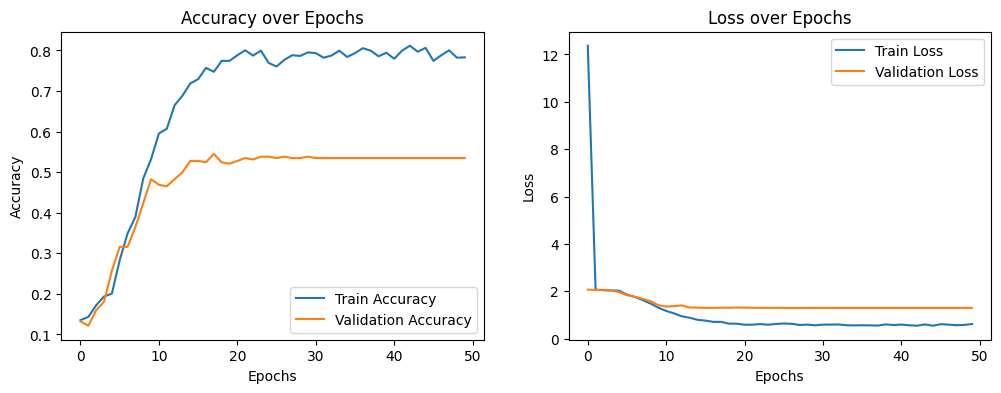

In [28]:
# --- Plotting Training History ---

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 335ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.55      0.67      0.60        39
        calm       0.57      0.71      0.64        38
     disgust       0.61      0.56      0.59        39
     fearful       0.68      0.59      0.63        39
       happy       0.50      0.34      0.41        38
     neutral       0.22      0.11      0.14        19
         sad       0.35      0.42      0.38        38
   surprised       0.58      0.66      0.62        38

    accuracy                           0.53       288
   macro avg       0.51      0.51      0.50       288
weighted avg       0.53      0.53      0.53       288



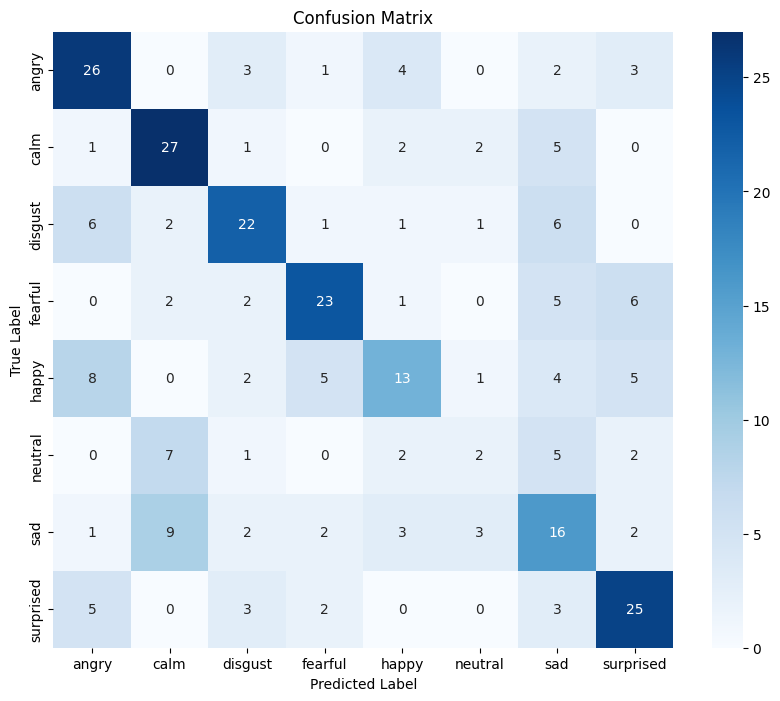

In [29]:
# --- Model Evaluation ---

# Predict on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get the class names from the encoder
class_names = encoder.classes_

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [31]:
# --- Real-world Prediction Function ---

def predict_emotion(file_path):
    """
    Loads an audio file, extracts features, and predicts the emotion.
    """
    # 1. Load and extract features using the SAME function as before
    mfccs = extract_features(file_path)

    # 2. Reshape the features for the model
    # The model expects a 4D input: (num_samples, height, width, channels)
    # Since we have only one file, num_samples is 1.
    mfccs_reshaped = np.expand_dims(mfccs, axis=0) # Adds the batch dimension (1, 40, 174)
    mfccs_reshaped = np.expand_dims(mfccs_reshaped, axis=-1) # Adds the channel dimension (1, 40, 174, 1)

    # 3. Make the prediction
    prediction = model.predict(mfccs_reshaped)

    # 4. Decode the prediction
    # Get the index of the highest probability
    predicted_index = np.argmax(prediction)
    # Use the encoder to get the emotion name back
    predicted_emotion = encoder.inverse_transform([predicted_index])

    return predicted_emotion[0]

# --- Example of How to Use It ---

# Let's test it on a file from our own test set to see if it works.
# We know the first file in X_test should correspond to the first label in y_test.
test_file_path = "/content/ravdess_data/Actor_01/03-01-01-01-01-01-01.wav" # This is a 'neutral' file

# Get the true emotion from the filename for comparison
true_emotion_code = test_file_path.split("-")[2]
true_emotion = emotions[true_emotion_code]

# Make a prediction
predicted_emotion = predict_emotion(test_file_path)

print(f"--- Testing on a new file ---")
print(f"File: {test_file_path}")
print(f"True Emotion: {true_emotion}")
print(f"Predicted Emotion: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
--- Testing on a new file ---
File: /content/ravdess_data/Actor_01/03-01-01-01-01-01-01.wav
True Emotion: neutral
Predicted Emotion: neutral


In [73]:
# --- Interactive Emotion Prediction Interface ---

# Import the necessary libraries for the interface
import ipywidgets as widgets
from IPython.display import display
import io

# We need to re-define the prediction function here so the interface can use it
# (This assumes 'model', 'encoder', and 'extract_features' are already in memory)

def predict_emotion_interface(file_content):
    """
    Takes file content, extracts features, and predicts the emotion.
    """
    try:
        # Create an in-memory file-like object from the uploaded content
        # librosa can load from a file-like object
        audio, sample_rate = librosa.load(io.BytesIO(file_content), duration=3, offset=0.5)

        # Extract MFCCs (this is the same logic as before)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        max_pad_len = 174
        if (mfccs.shape[1] < max_pad_len):
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, max_pad_len - mfccs.shape[1])), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]

        # Reshape for the model
        mfccs_reshaped = np.expand_dims(mfccs, axis=0)
        mfccs_reshaped = np.expand_dims(mfccs_reshaped, axis=-1)

        # Predict
        prediction = model.predict(mfccs_reshaped)
        predicted_index = np.argmax(prediction)
        predicted_emotion = encoder.inverse_transform([predicted_index])

        return predicted_emotion[0]

    except Exception as e:
        return f"Error: Could not process the file. {e}"

# --- Create the UI Widgets ---

# 1. A button to trigger the prediction
predict_button = widgets.Button(
    description='Predict Emotion',
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to predict the emotion of the uploaded audio',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

# 2. A file uploader widget
uploader = widgets.FileUpload(
    accept='.wav',  # Accepted file extension
    multiple=False  # Allow multiple files to be uploaded
)

# 3. An output widget to display the results
output = widgets.Output()

# --- Define the Logic  ---

def on_predict_button_clicked(b):
    """
    Function to run when the predict button is clicked.
    This version is updated to work with newer ipywidgets.
    """
    # Clear previous results
    output.clear_output()

    # Check if a file has been uploaded
    if not uploader.value:
        with output:
            print("Please upload a .wav file first!")
        return

    # --- This is the corrected part ---
    # Get the filename (the key) from the uploader's dictionary
    file_name = list(uploader.value.keys())[0]
    # Use the filename to get the file's content
    file_content = uploader.value[file_name]['content']

    with output:
        print(f"Analyzing file: {file_name}...")
        # Call our prediction function
        prediction = predict_emotion_interface(file_content)
        print(f"-------------------------------------------------")
        print(f" Predicted Emotion: {prediction.upper()} ")
        print(f"-------------------------------------------------")

# Link the button's click event to our function
predict_button.on_click(on_predict_button_clicked)

# --- Display the Interface ---
# We use a VBox to arrange the widgets vertically
display(widgets.VBox([uploader, predict_button, output]))

In [94]:
import ipywidgets as widgets
from IPython.display import display, HTML
import base64
import io
import numpy as np

# --- Helper Functions ---

def predict_emotion_from_bytes(audio_bytes):
    """Takes raw audio bytes, extracts features, and predicts the emotion."""
    try:
        import librosa
        import soundfile as sf
        import tempfile
        import os

        # Create a temporary file to handle the audio
        # WebM format needs to be saved to disk for proper processing
        with tempfile.NamedTemporaryFile(delete=False, suffix='.webm') as tmp_file:
            tmp_file.write(audio_bytes)
            tmp_path = tmp_file.name

        try:
            # Try to load the audio file
            # librosa can handle webm if ffmpeg is available
            audio, sample_rate = librosa.load(tmp_path, duration=3, offset=0.5, sr=None)

            # If the sample rate is too low, resample
            if sample_rate < 16000:
                audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=22050)
                sample_rate = 22050

            # Extract MFCC features
            mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
            max_pad_len = 174

            if (mfccs.shape[1] < max_pad_len):
                mfccs = np.pad(mfccs, pad_width=((0, 0), (0, max_pad_len - mfccs.shape[1])), mode='constant')
            else:
                mfccs = mfccs[:, :max_pad_len]

            mfccs_reshaped = np.expand_dims(mfccs, axis=0)
            mfccs_reshaped = np.expand_dims(mfccs_reshaped, axis=-1)

            # Make prediction
            prediction = model.predict(mfccs_reshaped)
            predicted_index = np.argmax(prediction)
            predicted_emotion = encoder.inverse_transform([predicted_index])

            return predicted_emotion[0]

        finally:
            # Clean up temporary file
            if os.path.exists(tmp_path):
                os.remove(tmp_path)

    except Exception as e:
        import traceback
        error_details = traceback.format_exc()
        return f"Error: {str(e)}\n\nDetails:\n{error_details}"

# --- Create the UI Widgets ---

# A file uploader widget
uploader = widgets.FileUpload(accept='.wav', multiple=False, description='Upload WAV File')

# Text area to receive base64 audio data (hidden from user)
audio_receiver = widgets.Textarea(
    value='',
    placeholder='',
    description='',
    disabled=False,
    layout=widgets.Layout(width='0px', height='0px', visibility='hidden')
)
# Add a unique DOM ID to the widget
audio_receiver.add_class('audio-data-receiver')

# An output widget to display status messages
output = widgets.Output()

# --- The Recording Interface ---

record_html = HTML("""
<div style='padding: 15px; background-color: #f8f9fa; border-radius: 5px; margin: 10px 0;'>
    <div style='margin-bottom: 10px;'>
        <button id='start-btn' onclick='startRecording()'
                style='padding: 10px 20px; background-color: #28a745; color: white; border: none;
                       border-radius: 5px; cursor: pointer; font-size: 14px; margin-right: 10px;'>
            Start Recording
        </button>
        <button id='stop-btn' onclick='stopRecording()' disabled
                style='padding: 10px 20px; background-color: #dc3545; color: white; border: none;
                       border-radius: 5px; cursor: pointer; font-size: 14px; margin-right: 10px;'>
            Stop Recording
        </button>
        <button id='predict-btn' onclick='predictFromRecording()' disabled
                style='padding: 10px 20px; background-color: #007bff; color: white; border: none;
                       border-radius: 5px; cursor: pointer; font-size: 14px;'>
            Predict Emotion
        </button>
        <span id='recording-status' style='margin-left: 15px;'></span>
    </div>

    <div id='audio-player' style='display: none; margin-top: 10px;'>
        <p><b>Preview your recording:</b></p>
        <audio id='recorded-audio' controls style='width: 100%;'></audio>
    </div>
</div>

<script>
let mediaRecorder;
let audioChunks = [];
let recordedData = null;

window.startRecording = async function() {
    try {
        const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
        mediaRecorder = new MediaRecorder(stream);
        audioChunks = [];

        mediaRecorder.ondataavailable = (event) => {
            audioChunks.push(event.data);
        };

        mediaRecorder.onstop = () => {
            const audioBlob = new Blob(audioChunks, { type: 'audio/webm' });
            const audioUrl = URL.createObjectURL(audioBlob);
            document.getElementById('recorded-audio').src = audioUrl;
            document.getElementById('audio-player').style.display = 'block';

            // Convert to base64 for Python
            const reader = new FileReader();
            reader.readAsDataURL(audioBlob);
            reader.onloadend = () => {
                recordedData = reader.result;
                document.getElementById('predict-btn').disabled = false;
            };
        };

        mediaRecorder.start();
        document.getElementById('recording-status').innerHTML =
            '<span style="color: red; font-weight: bold;">Recording...</span>';
        document.getElementById('start-btn').disabled = true;
        document.getElementById('stop-btn').disabled = false;
        document.getElementById('predict-btn').disabled = true;

    } catch (err) {
        alert('Error accessing microphone: ' + err.message);
    }
};

window.stopRecording = function() {
    if (mediaRecorder && mediaRecorder.state !== 'inactive') {
        mediaRecorder.stop();
        mediaRecorder.stream.getTracks().forEach(track => track.stop());
        document.getElementById('recording-status').innerHTML =
            '<span style="color: green; font-weight: bold;">Recording saved!</span>';
        document.getElementById('start-btn').disabled = false;
        document.getElementById('stop-btn').disabled = true;
    }
};

window.predictFromRecording = function() {
    if (!recordedData) {
        alert('No recording found! Please record audio first.');
        return;
    }

    document.getElementById('recording-status').innerHTML =
        '<span style="color: blue; font-weight: bold;">Processing...</span>';

    // Find the textarea with our custom class
    var targetTextarea = document.querySelector('textarea.audio-data-receiver');

    if (!targetTextarea) {
        // Fallback: try to find any hidden textarea
        var allTextareas = document.querySelectorAll('textarea');
        for (var i = 0; i < allTextareas.length; i++) {
            var style = window.getComputedStyle(allTextareas[i]);
            if (style.visibility === 'hidden' || style.width === '0px') {
                targetTextarea = allTextareas[i];
                break;
            }
        }
    }

    if (targetTextarea) {
        // Set the value - this will trigger the Python observer
        targetTextarea.value = recordedData;

        // Trigger change event using multiple methods to ensure it works
        targetTextarea.dispatchEvent(new Event('change', { bubbles: true }));
        targetTextarea.dispatchEvent(new Event('input', { bubbles: true }));

        // Force value update
        var nativeInputValueSetter = Object.getOwnPropertyDescriptor(window.HTMLTextAreaElement.prototype, "value").set;
        nativeInputValueSetter.call(targetTextarea, recordedData);
        targetTextarea.dispatchEvent(new Event('input', { bubbles: true }));

        console.log('Audio data sent to Python successfully');
    } else {
        alert('Error: Cannot find the data receiver widget. Please refresh the page and try again.');
        console.error('Could not find audio receiver textarea');
    }
};
</script>
""")

# --- Define the Logic ---

def on_audio_received(change):
    """Callback when audio data is received in the textarea."""
    if change['new'] and change['new'].startswith('data:audio'):
        output.clear_output()
        with output:
            print("Processing recording...")

        try:
            # Parse the base64 data
            header, encoded = change['new'].split(',', 1)
            audio_bytes = base64.b64decode(encoded)

            # Predict and show the result
            prediction = predict_emotion_from_bytes(audio_bytes)
            with output:
                output.clear_output()
                print("-------------------------------------------------")
                print(f"Predicted Emotion: {prediction.upper()}")
                print("-------------------------------------------------")

            # Clear the receiver for next time
            audio_receiver.value = ''

        except Exception as e:
            with output:
                output.clear_output()
                print(f"An error occurred: {e}")

def on_upload_change(change):
    """Handles file upload and predicts automatically."""
    output.clear_output()
    if uploader.value:
        uploaded_file = list(uploader.value.values())[0]
        file_content = uploaded_file['content']
        with output:
            print("Analyzing uploaded file...")
        prediction = predict_emotion_from_bytes(file_content)
        with output:
            output.clear_output()
            print("-------------------------------------------------")
            print(f"Predicted Emotion: {prediction.upper()}")
            print("-------------------------------------------------")

# Link the events
audio_receiver.observe(on_audio_received, names='value')
uploader.observe(on_upload_change, names='value')

# --- Display the Interface ---
print("=" * 60)
print("EMOTION PREDICTION FROM AUDIO")
print("=" * 60)
print("Choose one of the following options:")
print("  1. Upload a .wav file")
print("  2. Record audio using your microphone")
print("=" * 60)
display(uploader, record_html, audio_receiver, output)

EMOTION PREDICTION FROM AUDIO
Choose one of the following options:
  1. Upload a .wav file
  2. Record audio using your microphone


FileUpload(value={}, accept='.wav', description='Upload WAV File')

Textarea(value='', layout=Layout(height='0px', visibility='hidden', width='0px'), placeholder='', _dom_classes…

Output()